In [2]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, brier_score_loss, log_loss
from sklearn.metrics import classification_report, confusion_matrix 

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


# statistical reporting
import statsmodels.api as sm

# import custom functions
import sys
sys.path.append("../")
from projectname import custom_funcs

RANDOM = 0

## 1. Prep data

- load data 
- one-hot encode categorical features
- standard scale (zscore) continuous features
- split data into train-val and hold-out test sets 
- stratified CV folds, 3 folds repeated 5x with random sampling

In [3]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_922.csv")
df.shape

(922, 9)

In [4]:

# fix up some features
df['AGE'] = df.AGE.astype('float')
df['tumor_site'] = df.tumor_site.astype("category")

outcome = df['metastasis']
features = df.drop(columns =['metastasis'])


In [5]:
# log-transform skewed variables
#features['tumor_depth'] = features.tumor_depth.apply(lambda x: math.log(x))
#features['tumor_size_bins_cm'] = features.tumor_size_bins_cm.apply(lambda x: math.log(x))
#features.tumor_size_bins_cm.describe()

In [7]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_size_bins_cm', 'tumor_depth']
cat_features = ['tumor_site']
# interactions for everything but tumor site.
int_features = ['AGE', 'SEX', 'tumor_area', 'lymph_vasc_invasion', 'tumor_lymphocytes', 'immuno_suppressed']

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])
    # Build a preprocessing pipeline for categorical variables
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop = 'first'))])

from sklearn.preprocessing import PolynomialFeatures
# generate interaction terms from all features after transforming 
add_interactions = Pipeline(steps=[
    ('interaction_terms', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True))])

# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)],
   # ('int', add_interactions, int_features)],
    remainder = 'passthrough')

# Generate the preprocessor
preprocessed_X = preprocessor.fit_transform(features)
check_preproc = pd.DataFrame(preprocessed_X)
check_preproc.shape


(922, 10)

In [8]:
# split into train-test split, 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
# make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)

## Model: regularized logistic regression
- automated feature selection via L1 regularization  (Lasso)

In [9]:
Lasso_L1 = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                             penalty = 'l1', 
                              solver = 'liblinear', 
                             random_state = RANDOM)
Lasso_pipe = Pipeline(steps = [('preproc', preprocessor),
                              # ('interactions', add_interactions),
                              ('model', Lasso_L1)])

Lasso_pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'tumor_size_bins_cm',
                                                   'tumor_depth']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['tumor_site'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty='l1', random_state=0,
                                    solver='liblinear'))])

## Tune the model 
- grid search with different levels of regularization (parameter C)
- applied to cross-validation folds 
- get several metrics out! 


In [10]:
## DEFINE SCORES 
score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
              'f1': 'f1',
              'roc_auc': 'roc_auc', 
              'brier_score_loss': 'brier_score_loss'}

In [11]:
# define hyper-parametrs to tune 
# C is the inverse of alpha 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100] }

In [12]:
# define the grid search parameters 
Lasso_grid = GridSearchCV(Lasso_pipe,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)

In [13]:
# fit hte model 
Lasso_grid.fit(X_trainval, y_trainval)
# get the results and store them!
grid_results = pd.DataFrame(Lasso_grid.cv_results_)


In [14]:
# get log  of C for easier visualization
grid_results['param_model__C']= grid_results.param_model__C.astype('float')
grid_results['log_C'] = grid_results.param_model__C.map(lambda x: math.log(x))
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__C', 'params', 'split0_test_acc', 'split1_test_acc',
       'split2_test_acc', 'split3_test_acc',
       ...
       'split8_train_brier_score_loss', 'split9_train_brier_score_loss',
       'split10_train_brier_score_loss', 'split11_train_brier_score_loss',
       'split12_train_brier_score_loss', 'split13_train_brier_score_loss',
       'split14_train_brier_score_loss', 'mean_train_brier_score_loss',
       'std_train_brier_score_loss', 'log_C'],
      dtype='object', length=217)

In [15]:
# clean up dataframe so only have mean scores 
grid_results = grid_results[['param_model__C', 'log_C',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc', 
                             'mean_train_brier_score_loss', 'mean_test_brier_score_loss']]

# add PR_auc 
#*#*#*# TO DO 

In [16]:
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['param_model__C', 'log_C'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                          'mean_train_roc_auc', 'mean_test_roc_auc',
                                          'mean_train_brier_score_loss', 'mean_test_brier_score_loss'],
                                          
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['dataset'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# get rid of prefix 
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")


In [17]:
# chunk by metric 
accuracy_results =  grid_results_long[(grid_results_long.metric == "acc")]
recall_results = grid_results_long[(grid_results_long.metric == "recall")]
precision_results = grid_results_long[(grid_results_long.metric == "precision")]
f1_score_results = grid_results_long[(grid_results_long.metric == "f1")]
roc_auc_score_results = grid_results_long[(grid_results_long.metric == "roc_auc")]
brier_score_results = grid_results_long[(grid_results_long.metric == "brier_score_loss")]
#pr_auc_score # calculate.

## Visualize hyperparameter tuning: learning curves
- as a function of train vs validation sets 
- can see whether model is over-fit or underfit 

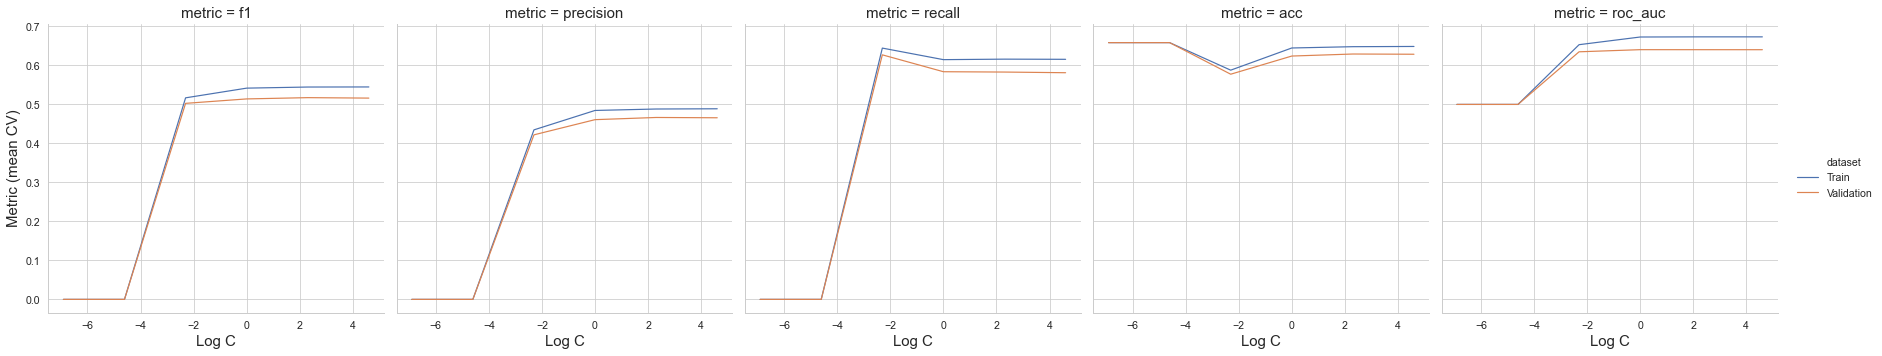

In [18]:
# figure of model comparisons on training  
g = sns.relplot(data = grid_results_long[grid_results_long.metric != "brier_score_loss"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset",  
                kind = "line", col = "metric")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Metric (mean CV)", size = 15)
g.set_titles(size = 15)


## Find the best model

In [19]:
best_metric = grid_results['mean_test_recall'].max()
best_model = pd.DataFrame(grid_results[grid_results['mean_test_recall']== best_metric])

print("Best Recall: {}".format(best_metric.round(2)))
print("Best C parameter: {}".format(best_model['param_model__C']))


Best Recall: 0.63
Best C parameter: 2    0.1
Name: param_model__C, dtype: float64


## Validate model on hold-out test set
### define & fit the model 
- using entire train-validation set.
- need to pre-process the data first!

In [64]:
# define and fit the model 
best_LR_model = LogisticRegression(class_weight = "balanced",
                                   max_iter = 1000,
                                   penalty = 'l1', 
                                   solver = 'liblinear',
                                   C = 0.1)

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = preprocessor.fit_transform(X_trainval)
preproc_X_test = preprocessor.fit_transform(X_test)

# fit the model to the entire train-validation set
best_LR_model.fit(preproc_X_trainval, y_trainval)

# confirming that sklearn adds an intercept! 
best_LR_model.intercept_

array([-0.18642145])

### get model scores on test set

In [65]:
y_pred = best_LR_model.predict(preproc_X_test)
# get scores 
best_test_scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc", "accuracy", "f1 score"],
                            "scores" : [precision_score(y_test, y_pred), 
                                       recall_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred),
                                       f1_score(y_test, y_pred)]
                           })
best_test_scores['scores'] = best_test_scores.scores.round(3)

print("Best Model scores on hold-out test set")
display(best_test_scores)# define and fit the model 


Best Model scores on hold-out test set


,metrics,scores
0,precision,0.416
1,recall,0.636
2,roc_auc,0.639
3,accuracy,0.641
4,f1 score,0.503


### get model predictions from the test set

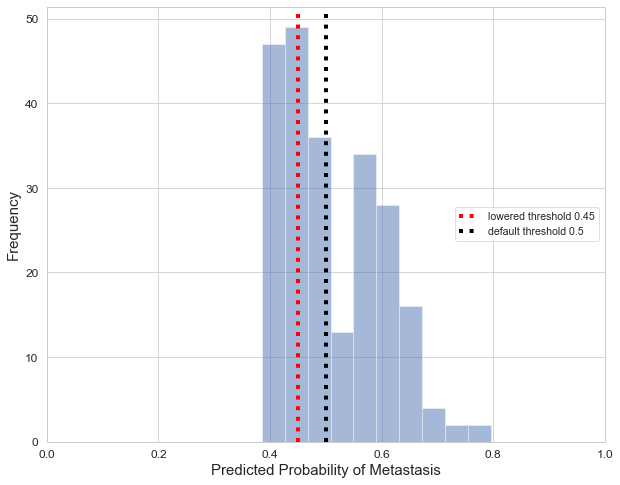

In [66]:
# get predictions on hold-out test set.
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]
custom_funcs.plot_predprobs(y_pred_prob, 0.45)

../projectname/custom_funcs.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../projectname/custom_funcs.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


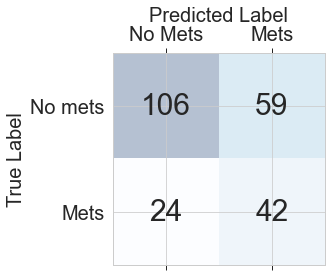

True negative rate: Patients with low risk, no biopsy necessary: 0.46
False negative rate: Patients mis-classified as low risk, but need biopsy: 0.36
True positive rate: Patients correctly classified as high risk, need biopsy: 0.18
False positive rate: Patients identified as high risk, but don't need biopsy: 0.36
Precision: Of all people recommended for biopsy, how many actually have metastasis? 0.42
Recall: Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.64


In [67]:
cm = confusion_matrix(y_test, y_pred)
custom_funcs.pretty_cm(cm, "../figures/NCDB_8_features_results/confusion_matrix_0.5.png")
custom_funcs.get_cm_info(cm, y_test) 

## Tuning the decision boundary 
- predicted probabilty > 0.4

../projectname/custom_funcs.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../projectname/custom_funcs.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


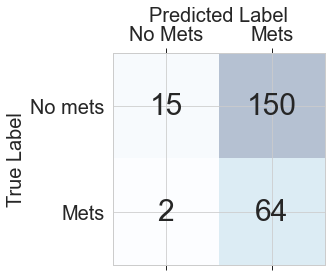

True negative rate: Patients with low risk, no biopsy necessary: 0.06
False negative rate: Patients mis-classified as low risk, but need biopsy: 0.03
True positive rate: Patients correctly classified as high risk, need biopsy: 0.28
False positive rate: Patients identified as high risk, but don't need biopsy: 0.91
Precision: Of all people recommended for biopsy, how many actually have metastasis? 0.3
Recall: Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.97


In [68]:
key_thresh = 0.4
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]
y_pred_adjusted  = y_pred_prob > key_thresh
cm = confusion_matrix(y_test, y_pred_adjusted)
custom_funcs.pretty_cm(cm, "../figures/NCDB_8_features_results/confusion_matrix_0.5.png")
custom_funcs.get_cm_info(cm, y_test)

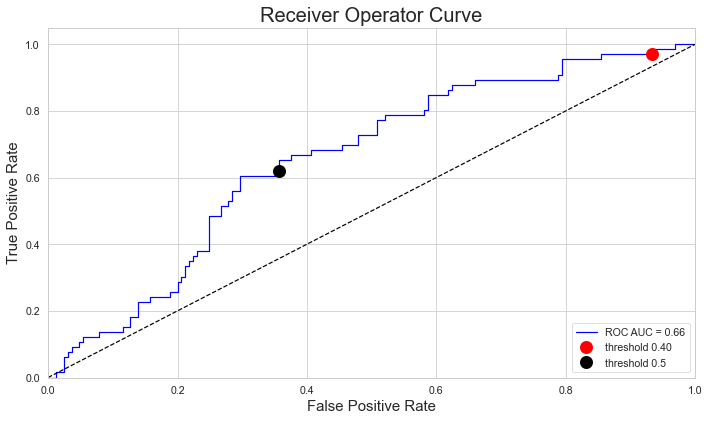

In [69]:
    
custom_funcs.plot_roc_curve(y_test, y_pred_prob, key_thresh)

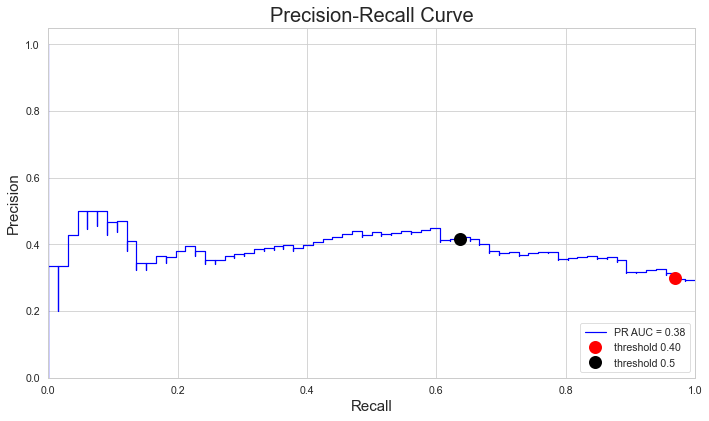

In [70]:

custom_funcs.plot_pr_curve(y_test, y_pred_prob, key_thresh)

## Calibrate prbabilities
- isotonic calibration is non-parametric, signmoid is parametric
- sigmoid works better.
- marginal improvement to brier score

In [71]:

platts_scaling = CalibratedClassifierCV(best_LR_model, cv=2, method='isotonic')
platts_scaling.fit(preproc_X_trainval, y_trainval)
calibrated_probs = platts_scaling.predict_proba(preproc_X_test)[:,1]

Lasso Regression:
	Brier: 0.243
	Precision: 0.416
	Recall: 0.636
	F1: 0.503

Lasso Regression + Isotonic:
	Brier: 0.198
	Precision: 0.360
	Recall: 0.136
	F1: 0.198



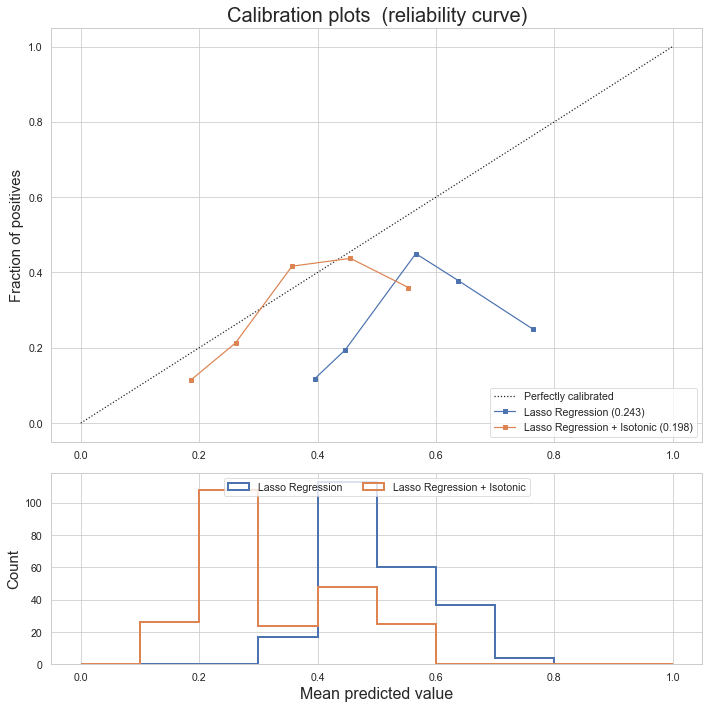

In [72]:

custom_funcs.plot_calibration_curve(best_LR_model, "Lasso Regression", 1,
                       preproc_X_trainval, preproc_X_test, y_trainval, y_test)

### Re-tune the decision boundary with calibrated probabilitiies
- 0.2 instead of 0.4
- so effectively, best we can get is identifying patients with < 20% risk

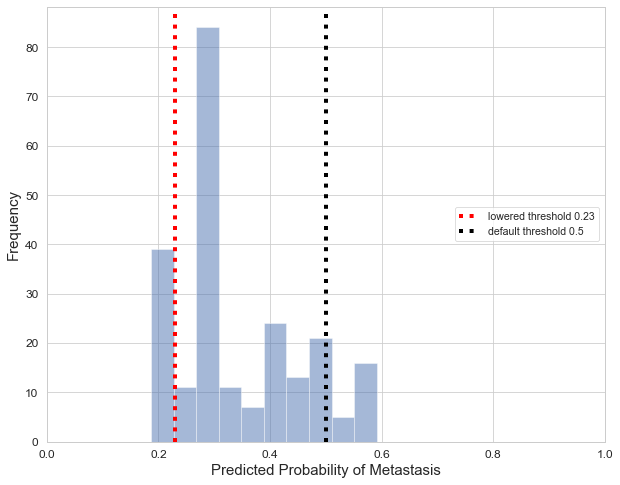

In [73]:

key_thresh = 0.23
custom_funcs.plot_predprobs(calibrated_probs, key_thresh)

../projectname/custom_funcs.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../projectname/custom_funcs.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


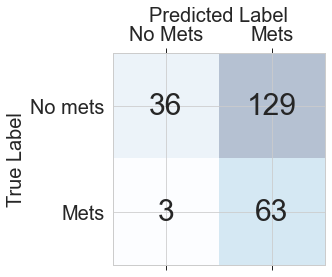

True negative rate: Patients with low risk, no biopsy necessary: 0.16
False negative rate: Patients mis-classified as low risk, but need biopsy: 0.05
True positive rate: Patients correctly classified as high risk, need biopsy: 0.27
False positive rate: Patients identified as high risk, but don't need biopsy: 0.78
Precision: Of all people recommended for biopsy, how many actually have metastasis? 0.33
Recall: Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.95


In [74]:
y_pred_calibrated = calibrated_probs > key_thresh
cm = confusion_matrix(y_test, y_pred_calibrated)
custom_funcs.pretty_cm(cm, "../figures/NCDB_8_features_results/confusion_matrix_calibrated.png")
custom_funcs.get_cm_info(cm, y_test)

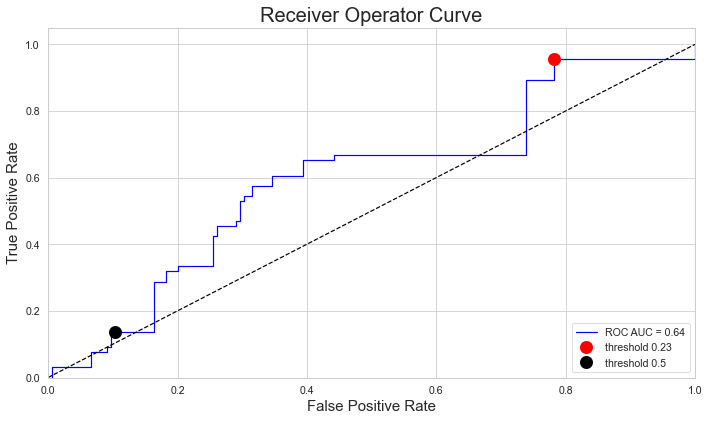

In [75]:
custom_funcs.plot_roc_curve(y_test, calibrated_probs, key_thresh)

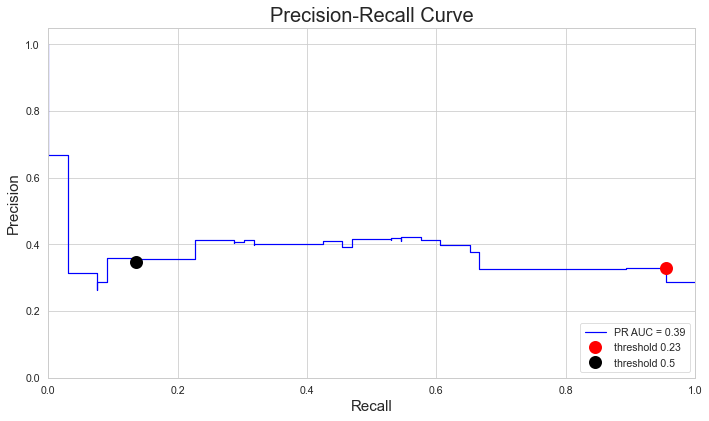

In [76]:
custom_funcs.plot_pr_curve(y_test, calibrated_probs, key_thresh)

## get feature importance / coefficients
### ... first, get feature names from preprocessed data
- note: tumor_site was dummy-encoded, with "Extremity" as the reference.

In [57]:
preproc_X_test_df = pd.DataFrame(preproc_X_test)
# apply the function to  get the featture names, because preprocessor mixes up order.
preproc_feature_names = custom_funcs.get_feature_names(preprocessor)
# check output!! 
preproc_feature_names


../projectname/custom_funcs.py:266: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  % (str(name), type(trans).__name__))


['num__AGE',
 'num__tumor_size_bins_cm',
 'num__tumor_depth',
 'onehot__x0_head_neck',
 'onehot__x0_other',
 'onehot__x0_trunk',
 'SEX',
 'immuno_suppressed',
 'tumor_lymphocytes',
 'lymph_vasc_invasion']

In [58]:
prettier_names = ['Age', 'Tumor size (cm)', 'Tumor depth (mm)', 
                 'Tumor site head/neck (vs extremity)',
                 'Tumor site other (vs extremity)', 'Tumor site trunk (vs extremity)',
                 'Sex', 'Immuno suppressed', 'Tumor lymphocytes', 'Lymph vascular invasion']
preproc_X_test_df.columns = prettier_names
# apply custom function to get coefficients from model 
coefs_df = custom_funcs.get_ordered_coefs(best_LR_model, preproc_X_test_df)


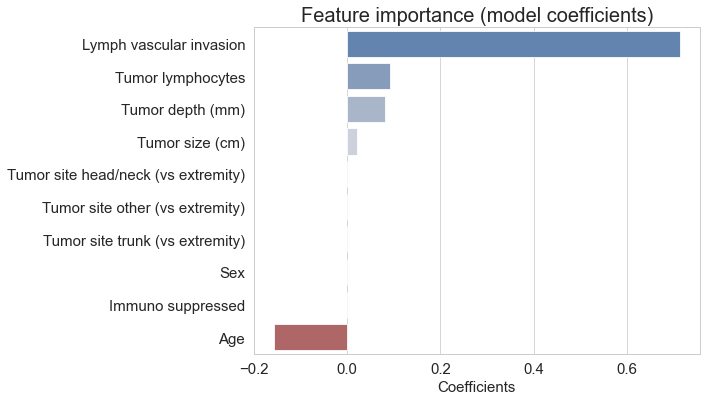

In [59]:

n_features =  coefs_df.shape[0]
plt.figure(figsize =  (8,6))
g = sns.barplot(data = coefs_df, y = 'features', x = "coefs",
            palette = sns.color_palette("vlag", n_features))
g.set_ylabel("")
g.tick_params(labelsize = 15)
g.set_xlabel("Coefficients", size = 15)
g.set_title("Feature importance (model coefficients)", size = 20);
plt.savefig('../figures/NCDB_8_features_results/best_LR_feature_weights.png', bbox_inches = 'tight')

## Confirm findings with statsmodels 
### fit Lasso model on trainval set 
- they don't match perfectly because i am balancing class weights in sklearn!
- if i remove that, they are near identical.


In [60]:
# set up X and y as arrays 
# need to explicitly add constant (intercept) to X data 
preproc_X_trainval_int = sm.add_constant(preproc_X_trainval)
y_trainval_array  = np.asarray(y_trainval)

In [61]:
# re-creating best model 
# C = 0.1, so alpha is inverse, should be 10 
log_reg = sm.Logit(y_trainval_array, preproc_X_trainval_int)
lasso_model = log_reg.fit_regularized(method = 'l1', alpha = 10)
print(lasso_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.637892498298106
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  691
Model:                          Logit   Df Residuals:                      685
Method:                           MLE   Df Model:                            5
Date:                Fri, 09 Oct 2020   Pseudo R-squ.:                 0.04398
Time:                        03:49:34   Log-Likelihood:                -424.14
converged:                       True   LL-Null:                       -443.65
Covariance Type:            nonrobust   LLR p-value:                 2.350e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [62]:
sklearn_coef = pd.DataFrame( best_LR_model.coef_.T, columns = ["sklearn"])
statmod_coef = pd.DataFrame(lasso_model.params[1:11], columns = ["statmod"])
features = pd.DataFrame(preproc_X_test_df.columns, columns = ["features"])
coefs_compare = pd.concat([features, sklearn_coef, statmod_coef],  axis = 1)
# close, but not exacctly.
coefs_compare

,features,sklearn,statmod
0,Age,-0.157291,-0.157604
1,Tumor size (cm),0.020772,0.005585
2,Tumor depth (mm),0.080990,0.080449
3,Tumor site head/neck (vs extremity),0.000000,0.000000
4,Tumor site other (vs extremity),0.000000,0.000000
5,Tumor site trunk (vs extremity),0.000000,0.000000
6,Sex,0.000000,-0.009349
7,Immuno suppressed,0.000000,0.000000
8,Tumor lymphocytes,0.091303,0.000000
9,Lymph vascular invasion,0.712973,0.594086


In [63]:
selected_features = coefs_compare.features[abs(coefs_compare.sklearn) > 0.05]
selected_features


0                        Age
2           Tumor depth (mm)
8          Tumor lymphocytes
9    Lymph vascular invasion
Name: features, dtype: object

### sanity check, run regular logiistic regression in stats models
- they are identical!!

In [33]:
# define and fit the model 
regular_LR_model = LogisticRegression(max_iter = 1000,
                                   penalty = 'none', solver = 'lbfgs')

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = preprocessor.fit_transform(X_trainval)
# fit the model to the entire train-validation set
regular_LR_model.fit(preproc_X_trainval, y_trainval)

# confirming that sklearn adds an intercept! 
regular_LR_model.intercept_

array([-1.2298153])

In [34]:
log_reg = sm.Logit(y_trainval_array, preproc_X_trainval_int)
log_model = log_reg.fit()
print(log_model.summary())



Optimization terminated successfully.
         Current function value: 0.601058
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  693
Model:                          Logit   Df Residuals:                      682
Method:                           MLE   Df Model:                           10
Date:                Wed, 07 Oct 2020   Pseudo R-squ.:                 0.05117
Time:                        13:32:27   Log-Likelihood:                -416.53
converged:                       True   LL-Null:                       -439.00
Covariance Type:            nonrobust   LLR p-value:                 2.243e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2298      0.303     -4.061      0.000      -1.823      -0.636
x1            -0.1461      0.

In [37]:
sklearn_coef = pd.DataFrame(regular_LR_model.coef_.T, columns = ["sklearn"])
statmod_coef = pd.DataFrame(log_model.params[1:11], columns = ["statmod"])
features = pd.DataFrame(preproc_X_test_df.columns, columns = ["features"])
coefs_compare = pd.concat([features, sklearn_coef, statmod_coef],  axis = 1)

coefs_compare

,features,sklearn,statmod
0,Age,-0.146072,-0.146078
1,Tumor size (cm),-0.004597,-0.004602
2,Tumor depth (mm),0.128445,0.128444
3,Tumor site head/neck (vs extremity),-0.016199,-0.016215
4,Tumor site other (vs extremity),-0.094968,-0.094970
5,Tumor site trunk (vs extremity),0.386220,0.386211
6,Sex,0.006202,0.006200
7,Immuno suppressed,0.286433,0.286403
8,Tumor lymphocytes,0.264939,0.264909
9,Lymph vascular invasion,0.842555,0.842557
